In [5]:
#Install the proper libraries needed
!pip install --upgrade pip
!pip install Pillow
!pip install matplotlib
!pip install py2neo==2.0
!pip install boto3
!pip install jgraph

from PIL import Image
import webbrowser
import datetime
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import json
from pprint import pprint
import boto3
import jgraph
from py2neo import Graph, authenticate, Relationship
import urllib
from scripts.rekgraph import rekrelationships
%matplotlib inline


The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
Requirement already up-to-date: pip in /home/ubuntu/anaconda2/lib/python2.7/site-packages (18.0)
The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and

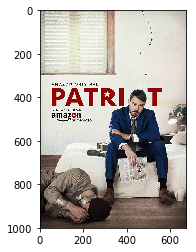

In [6]:
#retrieve and print a selected image
#use the same file name for each temp image or you will start getting a ton of photos
#stored in the folder
urllib.urlretrieve("https://images-na.ssl-images-amazon.com/images/M/MV5BNDgwNjI5MzY3Ml5BMl5BanBnXkFtZTgwNDE5NTAzMTI@._V1_SY1000_CR0,0,674,1000_AL_.jpg", "images/image1.jpg")                                                               
imshow(np.asarray(Image.open('images/image1.jpg', 'r')))

data type and length of the response from the detect_faces call
<type 'dict'>
3
the number of faces detected in the picture
1
printing face bounding boxes below

face number 0
0.344682633877
0.18952062726
0.40353089571
0.270345598459
width 183
height 276


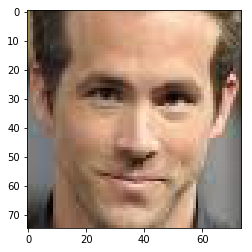

In [8]:
#detect faces in the first picture in the image
client = boto3.client('rekognition', region_name='us-east-1')
response = client.detect_faces(
    Image={
        'Bytes': open('images/image4.jpg','rb').read().strip()
    }
)
#the api returns a json dictionary of length 3
print('data type and length of the response from the detect_faces call')
print(type(response))
print(len(response))
 
#parsing out that dictionary
#print (response['ResponseMetadata'])
#print()
#print (response['FaceDetails'])
#print()
#print (response['OrientationCorrection'])
 
#print how many faces are in this picture
print('the number of faces detected in the picture')
faceCount=len(response['FaceDetails'])
print(faceCount)
 
if(faceCount>0):
    #next step is to show only the cropped faces
    #the IndexFaces api call will automatically take care of this parsing
    #for you when sending pictures with multiple faces to a FaceCollection.
    print('printing face bounding boxes below')
    counter=0
    #which of the faces from the photo do you want to print? rekognition makes the
    #largest face equal to index zero
    faceNumToKeep=0
    #these toKeep____ variables are to give flexibility
    #on which face to crop and print
    toKeepLeft=0.0
    toKeepTop=0.0
    toKeepWidth=0.0
    toKeepHeight=0.0
 
    #if you care to see the raw data that we parse in the for loop below
    #boundingBox=response['FaceDetails'][0]['BoundingBox']
    #print(boundingBox)
 
    #loop over each face and print the bounding boxes, save the one
    #specified by the faceNumToKeep param
    #for pictures with multiple faces, Rekognition starts with the largest face and moves iteratively to smaller ones
    for x in response['FaceDetails']:
        print('\nface number '+str(counter))
        boundingBox=x['BoundingBox']
        #print(boundingBox)
        print(boundingBox['Left'])
        print(boundingBox['Top'])
        print(boundingBox['Width'])
        print(boundingBox['Height'])
        if (counter==faceNumToKeep):
            toKeepLeft=boundingBox['Left']
            toKeepTop=boundingBox['Top']
            toKeepWidth=boundingBox['Width']
            toKeepHeight=boundingBox['Height']
        counter=counter+1
   
    #retrieve the whole photo, crop the face of interest and print                                                                 
    pil_im = Image.open('images/image4.jpg', 'r')
   
    picwidth=pil_im.size[0]
    picheight=pil_im.size[1]
    print('width '+str(picwidth))
    print('height '+str(picheight))
    imshow(np.asarray(pil_im.crop((
        picwidth*toKeepLeft,
        picheight*toKeepTop,
        picwidth*toKeepLeft+picwidth*toKeepWidth,
        picheight*toKeepTop+picheight*toKeepHeight
                             ))))
 

In [14]:
#detect celebrities
response = client.recognize_celebrities(
    Image={
        'Bytes': open('images/image4.jpg','rb').read().strip()
    }
)

print ('num celebrities found: '+str(len(response['CelebrityFaces'])))
for i in response['CelebrityFaces']:
    print i['Name']
    imageName = i['Name']
name1=response['CelebrityFaces'][0]['Name']


#detect celebrities
response = client.recognize_celebrities(
    Image={
        'Bytes': open('images/image3.jpg','rb').read().strip()
    }
)

print ('num celebrities found: '+str(len(response['CelebrityFaces'])))
for i in response['CelebrityFaces']:
    print i['Name']
    imageName = i['Name']
name1=response['CelebrityFaces'][0]['Name']


#detect celebrities
response = client.recognize_celebrities(
    Image={
        'Bytes': open('images/image5.jpg','rb').read().strip()
    }
)

print ('num celebrities found: '+str(len(response['CelebrityFaces'])))
for i in response['CelebrityFaces']:
    print i['Name']
    imageName = i['Name']
name1=response['CelebrityFaces'][0]['Name']



num celebrities found: 1
Ryan Reynolds
num celebrities found: 1
Dan Rather
num celebrities found: 1
John Belushi


In [17]:
authenticate("localhost:7474", "neo4j", "password")
graph = Graph()
graph.neo4j_version

(3, 1, 7)

In [21]:
query1="""
MATCH p=shortestPath(
  (p1:Person {name:"Kevin Bacon"})-[*]-(p2:Person {name:"Ryan Reynolds"})
)
UNWIND nodes(p) as n
RETURN n.name, n.title
"""
result1=graph.cypher.execute(query1)
pprint(result1)

query2="""
MATCH p=shortestPath(
  (p1:Person {name:"Kevin Bacon"})-[*]-(p2:Person {name:"John Belushi"})
)
UNWIND nodes(p) as n
RETURN n.name, n.title
"""
result2=graph.cypher.execute(query2)
pprint(result2)

   | n.name          | n.title     
---+-----------------+--------------
 1 | Kevin Bacon     |             
 2 |                 | Trapped     
 3 | Stuart Townsend |             
 4 |                 | Chaos Theory
 5 | Ryan Reynolds   |             

   | n.name       | n.title                        
---+--------------+---------------------------------
 1 | Kevin Bacon  |                                
 2 |              | National Lampoon's Animal House
 3 | John Belushi |                                



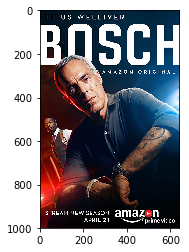

In [22]:
#now we bring it all together: bring in a second photo, and retrieve how the two actors/actresses know each other
urllib.urlretrieve("https://images-na.ssl-images-amazon.com/images/M/MV5BNjZjNjMyNDctZDNhOC00ODFlLTlmYzYtYjc2ZWMxNjNmYmE2XkEyXkFqcGdeQXVyNjI4OTg2Njg@._V1_SX640_CR0,0,640,999_AL_.jpg", "images/image2.jpg")                                                               
imshow(np.asarray(Image.open('images/image2.jpg', 'r')))

In [23]:
response = client.recognize_celebrities(
    Image={
        'Bytes': open('images/image2.jpg','rb').read().strip()
    }
)

print ('num celebrities found: '+str(len(response['CelebrityFaces'])))
for i in response['CelebrityFaces']:
    print i['Name']
    imageName = i['Name']
name2=response['CelebrityFaces'][0]['Name']

num celebrities found: 2
Titus Welliver
Jamie Hector


In [24]:
print "Querying Neo4j for connection between %s and %s!" % (name1, name2)
query="""
MATCH p=shortestPath(
  (p1:Person {name:"%s"})-[*]-(p2:Person {name:"%s"})
)
UNWIND nodes(p) as n
RETURN n.name, n.title
"""%(name1, name2)
print query
result=graph.cypher.execute(query)
print result
rekrelationships(graph,name1,name2)

Querying Neo4j for connection between John Belushi and Titus Welliver!

MATCH p=shortestPath(
  (p1:Person {name:"John Belushi"})-[*]-(p2:Person {name:"Titus Welliver"})
)
UNWIND nodes(p) as n
RETURN n.name, n.title

   | n.name           | n.title       
---+------------------+----------------
 1 | John Belushi     |               
 2 |                  | Neighbors     
 3 | John G. Avildsen |               
 4 |                  | Lean On Me    
 5 | Morgan Freeman   |               
 6 |                  | Gone Baby Gone
 7 | Titus Welliver   |               

